# Importing dependencies

In [4]:
pip install -U scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 14.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 6.0 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [5]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from tabulate import tabulate
from arch import arch_model
from arch.__future__ import reindexing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
%matplotlib inline
import arch
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.api as sm
from arch.univariate import GARCH
from sklearn.metrics import mean_squared_error, mean_absolute_error


# Acquiring TSLA stock df

In [6]:
df = pd.read_csv("TSLA_2022.csv")

In [7]:
df = pd.read_csv("SP_SC.csv")

In [8]:
df.tail(10)

,Date,Open,High,Low,Close,Adj Close,Volume,date,created_utc,reg_output
241,2022-12-16,159.639999,160.990005,150.039993,150.229996,150.229996,139032200,2022-12-16,1.671142e+09,0.038096
242,2022-12-19,154.000000,155.250000,145.820007,149.869995,149.869995,139390600,2022-12-19,1.671405e+09,-0.244484
243,2022-12-20,146.050003,148.470001,137.660004,137.800003,137.800003,159563300,2022-12-20,1.671507e+09,-0.118759
244,2022-12-21,139.339996,141.259995,135.889999,137.570007,137.570007,145417400,2022-12-21,1.671577e+09,-0.222528
245,2022-12-22,136.000000,136.630005,122.260002,125.349998,125.349998,210090300,2022-12-22,1.671663e+09,-0.114804
246,2022-12-23,126.370003,128.619995,121.019997,123.150002,123.150002,166989700,2022-12-23,1.671745e+09,-0.010171
247,2022-12-27,117.500000,119.669998,108.760002,109.099998,109.099998,208643400,2022-12-27,1.672101e+09,0.010060
248,2022-12-28,110.349998,116.269997,108.239998,112.709999,112.709999,221070500,2022-12-28,1.672179e+09,-0.110069
249,2022-12-29,120.389999,123.570000,117.500000,121.820000,121.820000,221923300,2022-12-29,1.672266e+09,0.016799
250,2022-12-30,119.949997,124.480003,119.750000,123.180000,123.180000,157777300,2022-12-30,1.672353e+09,-0.103723


# Calculating and plotting the daily returns

In [9]:
df['Return'] = 100 * (df['Adj Close'].pct_change())

In [10]:
#Dropping the first row since its NaN
df = df.drop(index=0) 


In [11]:
df

,Date,Open,High,Low,Close,Adj Close,Volume,date,created_utc,reg_output,Return
1,2022-01-04,396.516663,402.666656,374.350006,383.196655,383.196655,100248300,2022-01-04,1.641242e+09,-0.101193,-4.183270
2,2022-01-05,382.216675,390.113342,360.336670,362.706665,362.706665,80119800,2022-01-05,1.641334e+09,-0.218186,-5.347121
3,2022-01-06,359.000000,362.666656,340.166656,354.899994,354.899994,90336600,2022-01-06,1.641426e+09,-0.204311,-2.152337
4,2022-01-07,360.123322,360.309998,336.666656,342.320007,342.320007,84164700,2022-01-07,1.641517e+09,-0.248822,-3.544657
5,2022-01-10,333.333344,353.033325,326.666656,352.706665,352.706665,91815000,2022-01-10,1.641773e+09,-0.058042,3.034195
...,...,...,...,...,...,...,...,...,...,...,...
246,2022-12-23,126.370003,128.619995,121.019997,123.150002,123.150002,166989700,2022-12-23,1.671745e+09,-0.010171,-1.755083
247,2022-12-27,117.500000,119.669998,108.760002,109.099998,109.099998,208643400,2022-12-27,1.672101e+09,0.010060,-11.408854
248,2022-12-28,110.349998,116.269997,108.239998,112.709999,112.709999,221070500,2022-12-28,1.672179e+09,-0.110069,3.308892
249,2022-12-29,120.389999,123.570000,117.500000,121.820000,121.820000,221923300,2022-12-29,1.672266e+09,0.016799,8.082691


Text(0.5, 1.0, 'Daily Returns Over Time')

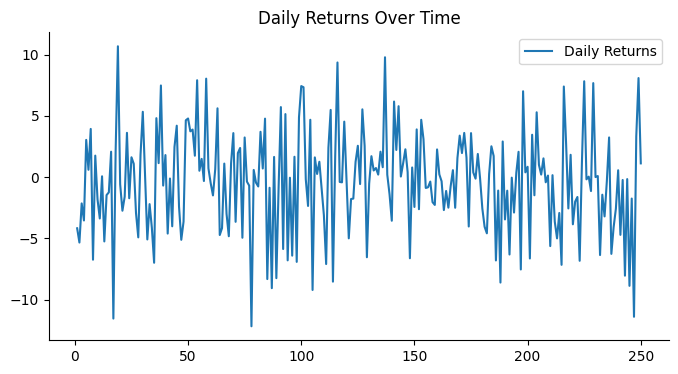

In [12]:
df.dropna(inplace=True)

fig,ax = plt.subplots(figsize=(8,4))
ax.spines[['top','right']].set_visible(False)
plt.plot(df['Return'], label = 'Daily Returns')
plt.legend(loc='upper right')
plt.title('Daily Returns Over Time')

# Calculating daily, monthly and annual volatility

In [13]:

daily_volatility = df['Return'].std()

monthly_volatility = math.sqrt(21) * daily_volatility

annual_volatility = math.sqrt(252) * daily_volatility

print(tabulate([['Tesla',daily_volatility,monthly_volatility,annual_volatility]],headers = ['Daily Volatility %', 'Monthly Volatility %', 'Annual Volatility %'],tablefmt = 'fancy_grid',stralign='center',numalign='center',floatfmt=".2f"))

╒═══════╤══════════════════════╤════════════════════════╤═══════════════════════╕
│       │  Daily Volatility %  │  Monthly Volatility %  │  Annual Volatility %  │
╞═══════╪══════════════════════╪════════════════════════╪═══════════════════════╡
│ Tesla │         4.12         │         18.86          │         65.33         │
╘═══════╧══════════════════════╧════════════════════════╧═══════════════════════╛


# Statistical Test | PART I.

#### Augmented Dickey-Fuller Test (ADF) / Test for stationarity

In [14]:
# Testing for stationarity in the df ('Returns' column)
# H0: The time series is non-stationary. In other words, it has some time-dependent structure and does not have constant variance over time
# H1: The time series is stationary

adfuller(df["Return"])

# Test statistic: -4.10658
# p-value: 0.00094
# Conlclusion: p-value < 0, so H0 is rejected. The returns are stationary

(-4.106586702076152,
 0.0009445273454100348,
 8,
 241,
 {'1%': -3.4577787098622674,
  '5%': -2.873608704758507,
  '10%': -2.573201765981991},
 1318.264829870127)

#### [CHECK AGAIN LATER!!!] / Jarque-Bera Test / Testing if the returns are normally distributed


In [15]:
# Why is it important? To see what distribution is best when fitting the GARCH models
# H0: The df follows a normal distribution
# H1: The df does not follow a normal distribution

# DOES NOT MAKE SENSE - returns not supposed to follow a normal distrubution but the test says so

#perform Jarque-Bera test
stats.jarque_bera(df["Return"])

# Null hypothesis is failed to be rejected
# The df seems to be following a normal distribution

SignificanceResult(statistic=0.9986487015255834, pvalue=0.606940600162593)

# ACF & PACF 

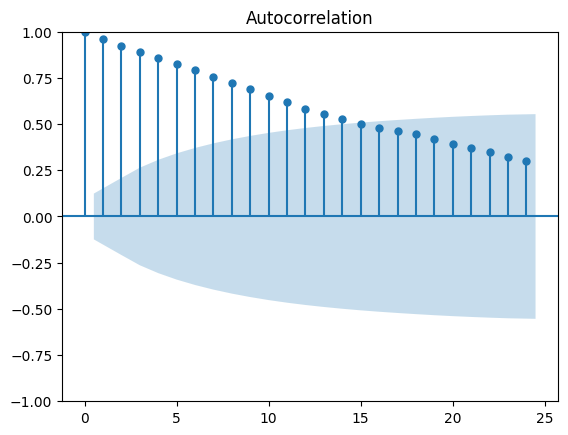

In [16]:
plot_acf(df['Adj Close']**2)
plt.show()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


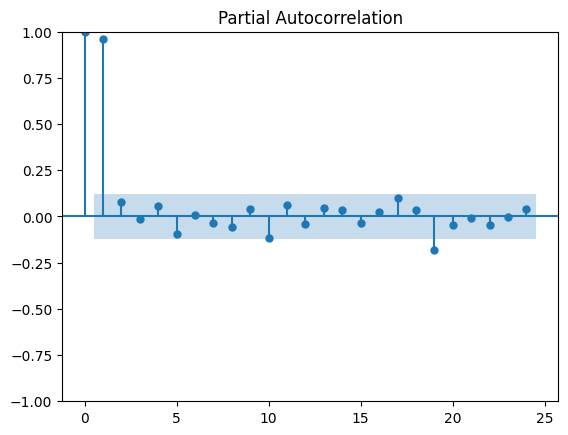

In [17]:
plot_pacf(df['Adj Close']**2)
plt.show()

# Normalizing our x values so that it fits the GJR - GARCH

In [18]:
# df['reg_output'] = (df['reg_output'] - np.min(df['reg_output']) + 1) / (np.max(df['reg_output']) - np.min(df['reg_output']) + 1)

# # min(x_normalized)

In [19]:
df['dummy'] = (df['reg_output'] < 0).astype(int)

In [20]:
df['reg_output_squared'] = df['reg_output']**2


In [21]:
df['Multiplication_dummy'] = df['reg_output_squared'] * df['dummy']

# GARCH(1,1) with normal distribution

In [22]:
garch_model = arch_model(df['Return'], p = 1, q = 1,
                      mean = 'constant', vol = 'GARCH', dist = 'normal')

gm_result = garch_model.fit(disp='off')
print(gm_result.params)

print('\n')

gm_forecast = gm_result.forecast(horizon = 1) # Q:What does horizon mean here?
print(gm_forecast.variance[-1:])              # A:The nr of steps ahead FC

mu         -0.364821
omega       0.768792
alpha[1]    0.020109
beta[1]     0.935147
Name: params, dtype: float64


           h.1
250  19.726717


In [23]:
gm_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                 Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -707.531
Distribution:                  Normal   AIC:                           1423.06
Method:            Maximum Likelihood   BIC:                           1437.15
                                        No. Observations:                  250
Date:                Wed, Mar 22 2023   Df Residuals:                      249
Time:                        16:35:42   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            -0.3648      0.266     -1.373      0.170 [ -0.886,  0.156]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.7688      0.490      1.568      0.117      [ -0.192,  1.729]
alpha[1]       0.0201  2.653e-02      0.758      0.449 [-3.190e-02,7.211e-02]
beta[1]        0.9351  2.563e-02     36.486 1.839e-291      [  0.885,  0.985]
=============================================================================

Covariance estimator: robust
"""

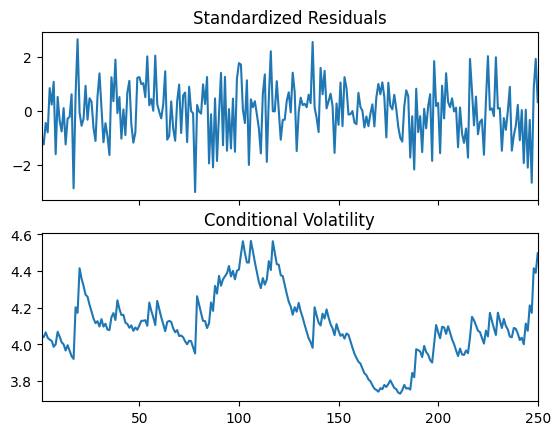

In [24]:
# Plot fitted results of GARCH (1,1)
gm_result.plot()
plt.show()

<Figure size 700x400 with 0 Axes>

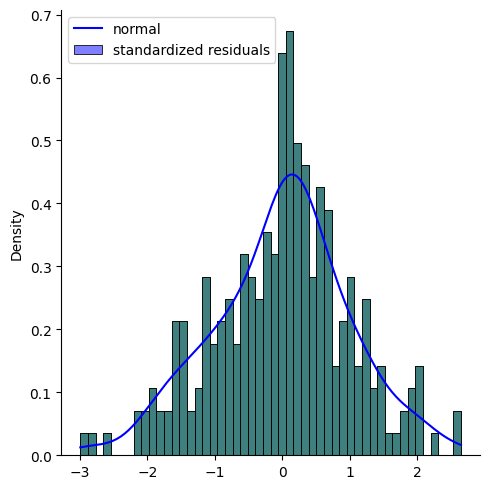

In [25]:
# Obtain model estimated residuals and volatility
gm_resid = gm_result.resid
gm_std = gm_result.conditional_volatility

# Calculate the standardized residuals
gm_std_resid = gm_resid / gm_std

# Plot the histogram of the standardized residuals
plt.figure(figsize=(7,4))
sns.displot(gm_std_resid, kde=True, stat="density", bins=50, color='b')
sns.histplot(gm_std_resid, stat="density", bins=50, color='g', alpha=0.5)
plt.legend(('normal', 'standardized residuals'))
plt.show()

# Statistical Tests | PART II.

#### Ljung-Box Test on the residuals

In [ ]:
# H0: The residuals are independently distributed
# H1: The residuals are not independently distributed; they exhibit serial correlation

sm.stats.acorr_ljungbox(gm_resid, lags=[25], return_df=True)

# p-value is less than 0.5, therefore the residuals exhibit serial correlation
# The GARCH(1,1) model is designed to capture the conditional heteroskedasticity 
#   in the df, and assuming that the model is correctly specified, the residuals 
#       should be independent and identically distributed. Any significant serial 
#           correlation in the residuals suggests that the model is not fully capturing 
#               the conditional heteroskedasticity or other patterns in the df

#NOTE: maybe we can try to adjust the number of lags

#### Jarque-Bera Test on the residuals / Test for normality in the residuals

In [ ]:
# H0: The residuals follows a normal distribution
# H1: The residuals does not follow a normal distribution

stats.jarque_bera(gm_resid)

# same as doing the tests for the returns (???)

# GARCH(1,1) with skewed t-distribution

In [ ]:
# Specify GARCH model assumptions
skewt_gm = arch_model(df['Return'], p = 1, q = 1, mean = 'constant', vol = 'GARCH', dist = 'skewt')

# Fit the model
skewt_result = skewt_gm.fit(disp = 'off')

# Get model estimated volatility
skewt_vol = skewt_result.conditional_volatility

In [ ]:
skewt_result.summary()
# AIC and BIC are higher than the GARCH (1,1) fitted with normal distribution

In [ ]:
# Plot model fitting results
plt.plot(skewt_vol, color = 'red', label = 'Skewed-t Volatility')
plt.legend(loc = 'upper right')
plt.show()

In [ ]:
plt.plot(skewt_vol, color = 'red', label = 'Skewed-t Volatility')
plt.plot(df['Return'], color = 'grey', 
         label = 'Daily Returns', alpha = 0.4)
plt.legend(loc = 'upper right')
plt.show()

# When plotting the model together with the returns, it is clear the model does not perform well / also what the information criteria indicates

# TARCH (1,1)

In [26]:
benchmark = arch.arch_model(df['Return'], mean='Constant', vol='GARCH', p=1, q=1, o=1, x=df['reg_output_squared'], power=1.0)


In [27]:
benchmark = benchmark.fit()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 2161.462886885749
Iteration:      2,   Func. Count:     17,   Neg. LLF: 2005.6047981345453
Iteration:      3,   Func. Count:     25,   Neg. LLF: 755.525809233103
Iteration:      4,   Func. Count:     32,   Neg. LLF: 703.8173183730248
Iteration:      5,   Func. Count:     38,   Neg. LLF: 711.7452962302194
Iteration:      6,   Func. Count:     46,   Neg. LLF: 734.1956390089251
Iteration:      7,   Func. Count:     55,   Neg. LLF: 703.7114992248636
Iteration:      8,   Func. Count:     62,   Neg. LLF: 703.0414559678467
Iteration:      9,   Func. Count:     68,   Neg. LLF: 703.0075089578238
Iteration:     10,   Func. Count:     74,   Neg. LLF: 703.0060796005776
Iteration:     11,   Func. Count:     80,   Neg. LLF: 703.0059929648629
Iteration:     12,   Func. Count:     86,   Neg. LLF: 703.0059421767819
Iteration:     13,   Func. Count:     91,   Neg. LLF: 703.0059421772687
Optimization terminated successfully    (Exit mode 0)
          

In [28]:
print(benchmark.summary())

                  Constant Mean - TARCH/ZARCH Model Results                   
Dep. Variable:                 Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                TARCH/ZARCH   Log-Likelihood:               -703.006
Distribution:                  Normal   AIC:                           1416.01
Method:            Maximum Likelihood   BIC:                           1433.62
                                        No. Observations:                  250
Date:                Wed, Mar 22 2023   Df Residuals:                      249
Time:                        16:36:02   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu            -0.4753      0.246     -1.935  5.303e-02 [ -0.957,

In [29]:
benchmark.pvalues.round(5)

mu          0.05303
omega       0.36522
alpha[1]    1.00000
gamma[1]    0.01232
beta[1]     0.00000
Name: pvalues, dtype: float64

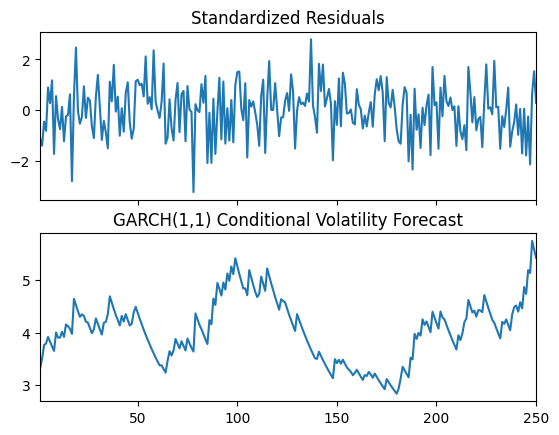

In [30]:
# Plot the conditional volatility forecast
fig = benchmark.plot()
plt.title("GARCH(1,1) Conditional Volatility Forecast")
plt.show()

In [31]:
cond_vol = benchmark.conditional_volatility

In [32]:
cond_vol

1      3.318220
2      3.504987
3      3.764282
4      3.793442
5      3.917180
         ...   
246    5.188794
247    5.133349
248    5.744031
249    5.578244
250    5.419124
Name: cond_vol, Length: 250, dtype: float64

In [33]:

actual_values = df['Return']

mse = mean_squared_error(actual_values, cond_vol)
mae = mean_absolute_error(actual_values, cond_vol)
rmse = np.sqrt(mse)

print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')


Mean Squared Error (MSE): 36.4973
Mean Absolute Error (MAE): 4.9563
Root Mean Squared Error (RMSE): 6.0413


# Minimizing Log-Likelihood

In [ ]:
#Model Selection Benchmark GARCH - Lowest Log-Likelihood
import itertools

# Define the range of p, q, and o to search over
p = range(1, 5)
q = range(1, 5)
o = range(1, 5)

# Create all combinations of p, q, and o
pqo = list(itertools.product(p, q, o))

# Define the exogenous variables
exog_vars = ['reg_output_squared']

# Initialize the log-likelihood and best model variables
best_loglik = -np.inf
best_model = None

# Loop over all combinations of p, q, and o
for i, (p, q, o) in enumerate(pqo):
    print(f"Fitting model {i+1} of {len(pqo)}: (p={p}, q={q}, o={o})")
    try:
        # Fit the ARX-GARCH model
        benchmark = arch_model(df['Return'], mean='Constant', vol='GARCH', p=p, q=q, o=o, x=df[exog_vars], power=1.0)

        res = benchmark.fit(disp='off')
        
        # Compute the log-likelihood and update the best model if necessary
        loglik = res.loglikelihood
        if loglik > best_loglik:
            best_loglik = loglik
            best_model = res
            print(f"New best model: (p={p}, q={q}, o={o}), log-likelihood={loglik:.2f}")
    except:
        continue

print("Done!")


# GARCH(1,4,2) has the lowest log-likelihood

In [ ]:
# Plot the actual stock returns
plt.plot(df['Return'], color = 'grey', alpha = 0.4, label = 'Price Returns')

# Plot GJR-GARCH estimated volatility
plt.plot(cond_vol, color = 'blue', label = 'Benchmark - GARCH(1,1) with exogenous')

plt.legend(loc = 'upper right')
plt.show()

# [DOES NOT WORK] EGARCH(1,1) with exogenous variable

In [ ]:
# Specify the EGARCH model with an exogenous variable
egarch_exo = arch_model(df['Return'], vol='EGARCH', p=1, o=1, q=1, x=df['reg_output_squared'], dist='normal')



#the model gives us pvalues of 0. Probably not correct


In [ ]:
egarch_exo =  egarch_exo.fit()

In [ ]:
print(egarch_exo.summary)

In [ ]:
egarch_exo.pvalues.round(5)

# Combined EGARCH (1,1) ARX Model

In [ ]:
combined_egarch_arx = arch_model(df['Return'], mean='ARX', lags=1, vol='EGARCH', p=1, q=1, x=df[['reg_output_squared', 'Multiplication_dummy']])

In [ ]:
combined_egarch_arx = combined_egarch_arx.fit()

In [ ]:
print(combined_egarch_arx.summary)

In [ ]:
combined_egarch_arx.pvalues.round(5)

# GJR GARCH with exogenous variable

In [ ]:
df

In [ ]:
# specify GJR-GARCH(1,1,1) model with a constant mean and an additional regressor
GJR_exo = arch_model(df['Return'], mean='Zero', vol='GARCH', p=1, q=1, o=1, x=df['reg_output_squared'], dist='skewt')

In [ ]:
GJR_exo = GJR_exo.fit()

In [ ]:
print(GJR_exo.summary)

In [ ]:
GJR_exo.pvalues.round(5)

In [ ]:
gjrgm_vol = GJR.conditional_volatility
benchmark = cond_vol

# Plot the actual stock returns
plt.plot(df['Return'], color = 'grey', alpha = 0.4, label = 'Price Returns')

# Plot GJR-GARCH estimated volatility
plt.plot(gjrgm_vol, color = 'blue', label = 'GJR-GARCH Volatility')

# Plot EGARCH  estimated volatility
plt.plot(benchmark, color = 'green', label = 'GARCH Volatility')

plt.legend(loc = 'upper right')
plt.show()

In [ ]:
gjrgm_vol = GJR.conditional_volatility
benchmark = cond_vol


# Plot GJR-GARCH estimated volatility
plt.plot(gjrgm_vol, color = 'blue', label = 'GJR-GARCH Volatility')


plt.legend(loc = 'upper right')
plt.show()

# Model Selection GJR 

In [ ]:
#Model Selection GJR - Lowest AIC
import itertools
import numpy as np
import pandas as pd
from arch import arch_model

# Define the range of p, q, and o to search over
p = range(1, 4)
q = range(1, 4)
o = range(1, 4)

# Create all combinations of p, q, and o
pqo = list(itertools.product(p, q, o))

# Define the exogenous variables
exog_vars = ['reg_output_squared', 'Multiplication_dummy']

# Initialize the AIC and best model variables
best_aic = np.inf
best_model = None

# Loop over all combinations of p, q, and o
for i, (p, q, o) in enumerate(pqo):
    print(f"Fitting model {i+1} of {len(pqo)}: (p={p}, q={q}, o={o})")
    try:
        # Fit the ARX-GARCH model
        model = arch_model(df['Return'], mean='ARX', lags=1, vol='GARCH', p=p, q=q, o=o, x=df[exog_vars])
        res = model.fit(disp='off')
        
        # Compute the AIC and update the best model if necessary
        aic = res.aic
        if aic < best_aic:
            best_aic = aic
            best_model = res
            print(f"New best model: (p={p}, q={q}, o={o}), AIC={aic:.2f}")
    except:
        continue

print("Done!")

In [ ]:
import itertools
import numpy as np
import pandas as pd
from arch import arch_model

# Define the range of p, q, and o to search over
p = range(1, 4)
q = range(1, 4)
o = range(1, 4)

# Create all combinations of p, q, and o
pqo = list(itertools.product(p, q, o))

# Define the exogenous variables
exog_vars = ['reg_output_squared', 'Multiplication_dummy']

# Initialize the BIC and best model variables
best_BIC = np.inf
best_model = None

# Loop over all combinations of p, q, and o
for i, (p, q, o) in enumerate(pqo):
    print(f"Fitting model {i+1} of {len(pqo)}: (p={p}, q={q}, o={o})")
    try:
        # Fit the ARX-GARCH model
        model = arch_model(df['Return'], mean='ARX', lags=1, vol='GARCH', p=p, q=q, o=o, x=df[exog_vars])
        res = model.fit(disp='off')
        
        # Compute the BIC and update the best model if necessary
        bic = res.bic
        if bic < best_bic:
            best_bic = bic
            best_model = res
            print(f"New best model: (p={p}, q={q}, o={o}), BIC={bic:.2f}")
    except:
        continue

print("Done!")

In [ ]:
#Model Selection GJR - Lowest Log-Likelihood
import itertools
import numpy as np
import pandas as pd
from arch import arch_model

# Define the range of p, q, and o to search over
p = range(1, 5)
q = range(1, 5)
o = range(1, 5)

# Create all combinations of p, q, and o
pqo = list(itertools.product(p, q, o))

# Define the exogenous variables
exog_vars = ['reg_output_squared', 'Multiplication_dummy']

# Initialize the log-likelihood and best model variables
best_loglik = -np.inf
best_model = None

# Loop over all combinations of p, q, and o
for i, (p, q, o) in enumerate(pqo):
    print(f"Fitting model {i+1} of {len(pqo)}: (p={p}, q={q}, o={o})")
    try:
        # Fit the ARX-GARCH model
        model = arch_model(df['Return'], mean='ARX', lags=1, vol='GARCH', p=p, q=q, o=o, x=df[exog_vars])
        res = model.fit(disp='off')
        
        # Compute the log-likelihood and update the best model if necessary
        loglik = res.loglikelihood
        if loglik > best_loglik:
            best_loglik = loglik
            best_model = res
            print(f"New best model: (p={p}, q={q}, o={o}), log-likelihood={loglik:.2f}")
    except:
        continue

print("Done!")


# [NOT USED] Rolling Predictions


In [ ]:
# training df size = 200 (80%)
# test df size = 50 (20%)

In [ ]:
rolling_predictions = []
test_size = 50

for i in range(test_size):
    train = df['Return'][:-(test_size-i)]
    model = arch_model(train, p=1, q=1)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1) #could the horizen be the number of periods we want to FC
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))
    
rolling_predictions = pd.Series(rolling_predictions, index=df['Return'].index[-50:])

fig,ax = plt.subplots(figsize=(10,4))
ax.spines[['top','right']].set_visible(False)
plt.plot(rolling_predictions)
plt.title('Rolling Prediction')

In [ ]:
fig,ax = plt.subplots(figsize=(13,4))
ax.grid(which="major", axis='y', color='#758D99', alpha=0.3, zorder=1)
ax.spines[['top','right']].set_visible(False)
plt.plot(df['Return'][-50:])
plt.plot(rolling_predictions)
plt.title('Tesla Volatility Prediction - Rolling Forecast')
plt.legend(['True Daily Returns', 'Predicted Volatility'])

# [NOT USED] Fitting the rolling prediction model and relevant statistics

In [ ]:
df

In [ ]:
# Define the GARCH(1,1) model with an exogenous variable in the volatility equation
model = arch_model(df['Return'], p=1, q=1, x=df[['reg_output_squared']], vol='Garch', dist='Normal')


In [ ]:
# Fit the model
results = model.fit()

In [ ]:
# Print model summary
print(results.summary())